In [1]:
import torch
import torch.nn as nn

import sys
sys.path.insert(0,'..')
from utils.checkpoint import CheckPointer
from models.encoder import Encoder
from models.decoder import FrameLSTM, EventLSTM
from models.attention import Attention1,Attention2
from models.models import Model3

from collections import defaultdict, OrderedDict
import matplotlib.pyplot as plt
from matplotlib.image import imread
import numpy as np
import glob
import os

from PIL import Image
import torch
import torchvision.transforms as transforms
from tqdm import tqdm
import glob
import pickle
%load_ext autoreload
%autoreload 2

In [2]:
joint_details = {1 : 'HEAD',
                 2 : 'NECK',
                 3 : 'TORSO',
                 4 : 'LEFT_SHOULDER',
                 5 : 'LEFT_ELBOW',
                 6 : 'LEFT_HAND',
                 7 : 'RIGHT_SHOULDER',
                 8 : 'RIGHT_ELBOW',
                 9 : 'RIGHT_HAND',
                 10 : 'LEFT_HIP',
                 11 : 'LEFT_KNEE',
                 12 : 'LEFT_FOOT',
                 13 : 'RIGHT_HIP',
                 14 : 'RIGHT_KNEE',
                 15 : 'RIGHT_FOOT'}
connect_map = [[1,2,2,2,3,3,3,3,4,5,7,8,10,11,13,14],[2,3,4,7,4,7,10,13,5,6,8,9,11,12,14,15]]

def plot_frames(frames_code,reqd_pose_data, frames_pth, acts):
    
    frames_code = [int(x) for x in frames_code.strip().split('-')]
    
    for idx,row in enumerate(reqd_pose_data):
        posture = row

        posture_data = [x.strip() for x in posture.split(',')]

        joint_info = {}
        for i, n in enumerate(range(1, len(posture_data), 3)):

            x = 640 - float(posture_data[n])*640
            y = 480 - (float(posture_data[n+1])/1)*480
            z = posture_data[n+2]

            joint_info[i+1] = [x, y, z]

        person_1 = {k:joint_info[k] for k in range(1,16,1)}
        #print(person_1)
        person_2 = {k-15:joint_info[k] for k in range(16,31,1)}
        # print(person_1)

        count1 = 15
        for i, (x,y,z) in list(person_1.items()):
            if x<0 or x>640 or y<0 or y>480:
                    count1 -= 1

        count2 = 15
        for i, (x,y,z) in list(person_2.items()):
            if x<0 or x>640 or y<0 or y>480:
                    count2 -= 1
                    
        wt1 , wt2 = acts[idx][0], acts[idx][1]
                    
#         if frames_code[2]==2:
#             wt1, wt2 = wt2, wt1

        print(wt1, wt2)
        for key, value in person_1.items():
            plt.plot(value[0], value[1], 'bo', markersize=2)
        for m, n in zip(connect_map[0], connect_map[1]):
            plt.plot((person_1[m][0], person_1[n][0]), (person_1[m][1], person_1[n][1]), 'b--', linewidth=5*wt1)

        for key, value in person_2.items():
            plt.plot(value[0], value[1], 'go', markersize=2)
        for m, n in zip(connect_map[0], connect_map[1]):
            plt.plot((person_2[m][0], person_2[n][0]), (person_2[m][1], person_2[n][1]), 'g--', linewidth=5*wt2)

        plt.xlim(0, 640)
        plt.ylim(0, 480)


        img = np.array(plt.imread(frames_pth[idx]))
        img = img[::-1,:,:]
        plt.imshow(img)
        plt.pause(0.1)
        plt.clf()
        

In [3]:
model_pth = '/usr/local/data01/rohitram/sbu-snapshots/model3/d=F,seed=default,framew=default,framefb=default,eventw=default,eventfb=default,ep=500,attn=2/no_scheduler/fold=1/run=1/Jul19_04-09-55/best.pth'

model = Model3(eventLSTM = {'hidden_size':256}, pose_dim=30, num_classes=8, attention_type=2)
ckpt = CheckPointer([model])
ckpt.load_checkpoint(model_pth)

model.cuda()

Loading checkpoint from /usr/local/data01/rohitram/sbu-snapshots/model3/d=F,seed=default,framew=default,framefb=default,eventw=default,eventfb=default,ep=500,attn=2/no_scheduler/fold=1/run=1/Jul19_04-09-55/best.pth
current best metrics {'val_accuracy': tensor(0.6545, device='cuda:0'), 'val_loss': 1.2751075397838245}


Model3(
  (attention): Attention2(
    (mlp): Sequential(
      (0): Linear(in_features=286, out_features=64, bias=False)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=1, bias=False)
    )
  )
  (eventLSTM): EventLSTM(
    (eventLSTM): LSTM(30, 256, batch_first=True)
  )
  (fc): Linear(in_features=256, out_features=8, bias=True)
)

In [4]:
def get_weights(name):
    def hook(model, input, output):
        print(output[1])
        activation[name].append(output[1][0].detach().cpu().numpy())
    return hook


model.attention.register_forward_hook(get_weights('attention'))

In [5]:
reqd_pose_data = None
rgb_images = None
start = None
end = None

def get_pose_inp(frames_code):
    global reqd_pose_data, rgb_images, start, end
    
    dataset_pth = "/usr/local/data02/dpdataset/sbu/"
    
    set_no, action, run = [int(x) for x in frames_code.strip().split('-')]  

    part_sets = sorted(os.listdir(dataset_pth))
    part_name = part_sets[set_no - 1]
    set_no = '%02d' % action
    run = '%03d' % run


    frames_pth = os.path.join(dataset_pth,part_name,set_no,run)
    rgb_images = sorted(glob.glob(f'{frames_pth}/rgb*'))

    select_frames = 10
    start = (len(rgb_images) - select_frames)//2
    end = start+select_frames

    # req_images = rgb_images[start:end]
    # read_images = [Image.open(x).convert('RGB') for x in req_images]

    with open(os.path.join(frames_pth, "skeleton_pos.txt"), "r") as f:
        pose_data = f.readlines()

    reqd_pose_data = pose_data[start:end]

    video_pose_values = []
    for row in reqd_pose_data:
        posture_data = [x.strip() for x in row.split(",")]
        frame_pose_values = [float(x) for x in posture_data[1:]]
        assert len(frame_pose_values) == 90, "incorrect number of pose values"
        video_pose_values.append(frame_pose_values)  

    video_pose_values = torch.tensor(video_pose_values, dtype=torch.float32)


    idxs = torch.tensor([i for i in range(90) if (i+1)%3!=0])
    loaded_poses = video_pose_values[:,idxs]
    keypoints_per_person = 30

    pose_values = loaded_poses.view(loaded_poses.shape[0],2,keypoints_per_person)
    
    inp = pose_values.unsqueeze(0)
    inp = inp.cuda()
    
    return inp

tensor([[0.1900, 0.8100]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[0.0935, 0.9065]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[0.0658, 0.9342]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[0.0542, 0.9458]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[0.0519, 0.9481]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[0.0529, 0.9471]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[0.0550, 0.9450]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[0.0519, 0.9481]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[0.0507, 0.9493]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[0.0515, 0.9485]], device='cuda:0', grad_fn=<SoftmaxBackward>)
0.1900364 0.8099636


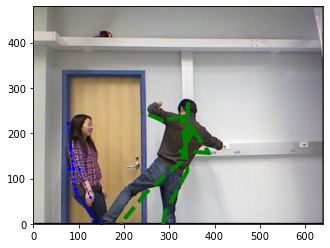

0.09349194 0.906508


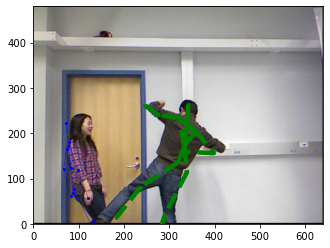

0.06576119 0.93423885


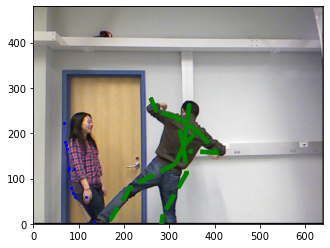

0.054188587 0.94581145


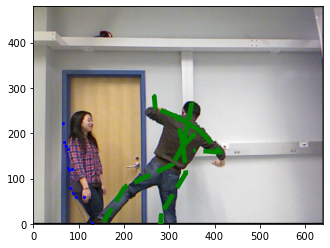

0.05191574 0.9480843


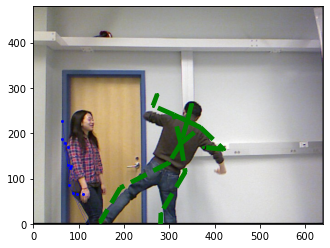

0.052856304 0.9471437


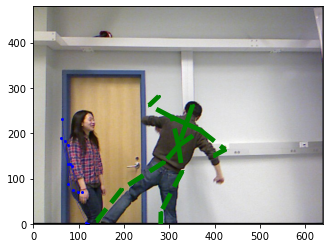

0.055022 0.94497806


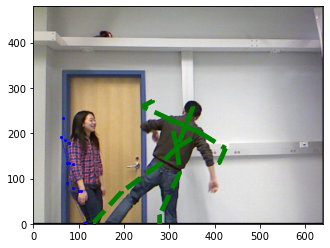

0.051935036 0.948065


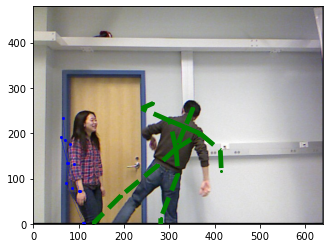

0.05074862 0.94925135


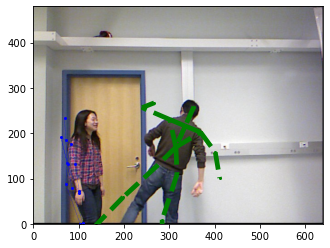

0.051504444 0.9484955


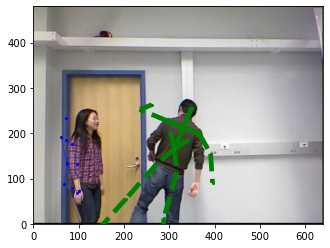

<Figure size 432x288 with 0 Axes>

In [18]:
#set (1-21) - action (1-8) - participant_run (1/2/3)

frames_code = '19-3-2' #kicking
# frames_code = '3-8-1' #punching
# frames_code = '1-1-1' #approaching

# frames_code = '9-3-1' #kicking ## pose data inverted!!

activation = {'attention':[]}
output = model(get_pose_inp(frames_code))

plot_frames(frames_code,reqd_pose_data, rgb_images[start:end],activation['attention'])